# PyTorch学习 Part1

### Tensor是什么？
在 PyTorch 中，Tensor 是最基本的数据结构，它类似于 NumPy 中的多维数组，但额外支持：
- 自动求导（autograd）
- GPU 加速（CUDA）
- 广播机制（Broadcasting）

In [3]:
import torch

# Scalar
a = torch.tensor(5)
print(f'Scalar: {a} | Shape: {a.shape}')

# Vector
b = torch.tensor([1, 2, 3])
print(f'Vector: {b} | Shape: {b.shape}')

# Matrix
c = torch.tensor([[1,2],[3,4]])
print(f'Matrix: {c} | Shape: {c.shape}')

# Tensor
d = torch.randn(2,3,4)
print(f'Tensor: {d} | Shape: {d.shape}')

Scalar: 5 | Shape: torch.Size([])
Vector: tensor([1, 2, 3]) | Shape: torch.Size([3])
Matrix: tensor([[1, 2],
        [3, 4]]) | Shape: torch.Size([2, 2])
Tensor: tensor([[[-0.9934, -1.1354,  0.5186,  0.0655],
         [-1.2734,  1.3835, -2.8503,  0.8640],
         [-1.7711, -0.6974,  0.4171, -0.4670]],

        [[-0.9032, -0.8762,  1.1044,  0.7193],
         [-1.1354,  0.5581, -0.1455,  0.7685],
         [ 0.3139,  0.5544, -0.8425, -0.4920]]]) | Shape: torch.Size([2, 3, 4])


- Tensor是PyTorch中的多维数组结构，支持自动求导和GPU加速，属于深度学习的核心计算单位
- Tensor的默认设备是CPU，不过可以通过'.cuda()'或者'.to('cuda')'移动到GPU上面
- 如何创建一个3*4的Tensor？torch.randn(3,4)
- Tensor和Numpy有什么不同？Tensor可以反向传播，可以GPU加速，功能更强

### 改变Tensor的形状

在深度学习中，Tensor的形状经常(Shape)经常需要匹配模型的输入结构，比如：
- 图像模型：需要输入的结构是(B, C, H, W) -- (batch, channel, height, width)
- NLP模型：需要输入的结构是(batchm, seq_length)
我们必须熟悉的调整Tensor的形状，而不能生成新的数据，这就view/reshape的用武之地

In [ ]:
# view() & reshape()
x = torch.randn(2,3,4)
print(f"x's original shape: {x.shape}") # 这里的Tensor有三个维度(batch， height, width)，可以想象城两个3*4的矩阵叠在一起


# 使用view()改变形状，把上面的Tensor变成一个6*4的矩阵
x_reshaped = x.view(6,4)
print(f'x_reshaped shape: {x_reshaped.shape}')

### 注意，view要求Tensor在内存中是连续的，但是reshape会自动处理，所以更推荐使用reshape；如果内存不连续，使用view之前需要先使用contiguous()

x's original shape: torch.Size([2, 3, 4])
x_reshaped shape: torch.Size([6, 4])


In [ ]:
# squeeze() & unsqueeze()
x = torch.tensor([1.0, 2.0, 3.0])
print(f"x's original shape: {x.shape}")
# 添加一个batch维度，作为一个batch输入模型
x_batch= x.unsqueeze(0)
print(f'x_batch shape: {x_batch.shape}')
# 在添加一个维度
x_more = x_batch.unsqueeze(-1)
print(f'x_more shape: {x_more.shape}')
# 再删除上一步添加的维度
x_back = x_more.squeeze(-1)
print(f'x_back shape: {x_back.shape}')


x's original shape: torch.Size([3])
x_batch shape: torch.Size([1, 3])
x_more shape: torch.Size([1, 3, 1])
x_back shape: torch.Size([1, 3])


### 模型输入通常会用到unsqueeze(0)， 是因为要添加batch维度

- view()和reshape()用来改变tensor的维度，reshape更加灵活因为不要求内存连续；unsqueeze()在指定位置添加维度，squeeze删除shape=1的维度
- 注意view()要求连续内存，所以为了保证view()不出错，我们可以保持tensor.contiguous().view(.., ..)的形式

**Tensor 的 view/reshape 虽然常用于适配模型结构，但我们更应该从数据本身的语义出发来设计输入格式，而不是反过来为了迎合模型而强行 reshape。否则会引入结构错误，比如跨样本 flatten、多维错位等问题。**

In [11]:
# view() & reshape() 的常见实用场景

# （1）适用于CNN输出支全连接层
x = torch.randn(32, 64, 7, 7)
x_flatten = x.contiguous().view(32,-1) # '-1'代表让机器自动计算维度，这里的意思是保留32， -1处自动计算--64*7*7
print(f'Flatten shape: {x_flatten.shape}')

# （2）增加batch和通道维度
img = torch.randn(28, 28) # 目前只有height，width两个维度
img = img.unsqueeze(0).unsqueeze(0) # 我们需要增加batch和channel两个维度
print(f'Image shape: {img.shape}')


Flatten shape: torch.Size([32, 3136])
Image shape: torch.Size([1, 1, 28, 28])


### Broadcasting机制
- broadcasting机制是**右对齐维度**：从后往前比，如果两个tensor的维度不一样，会先在最前面补1，使他们的维度一样。 比如A.shape = (2, 3, 1), B.shape = (3，4)， B会先变成(1,3,4)，然后在进行广播
- 然后是每一个维度的比较规则，看是都可以进行braodcasting
  - 1.维度大小相等；2.一个是 1，一个不是。 如果两个都不是1且双方不相等，那么不可以broadcasting，直接报错
  - broadcasting后的维度为最大维度的组合

In [12]:
import torch

A = torch.randn(2, 3, 1)
B = torch.randn(3, 4)

# 自动补维
# A: (2, 3, 1)
# B: (1, 3, 4)

# 比较维度：
# (1 vs 4) ✅ → A扩展
# (3 vs 3) ✅
# (2 vs 1) ✅ → B扩展

# 最终广播形状：(2, 3, 4)

### Autograd, requires_grad, detach和PyTorch的自动微分机制
- PyTorch 的 Autograd 模块会自动构建一张计算图（computation graph），追踪 Tensor 的所有运算过程，从而实现自动求导。
- 每当你对一个 requires_grad=True 的 Tensor 进行操作时，PyTorch 就在背后记录这些操作，以便之后使用 .backward() 自动计算梯度

In [ ]:
# requires_grad
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
# requires_grad设置为True，表示这个Tensor需要梯度计算
# **requires_grad默认是False**，只做前向传播的计算，不做反向传播



# 如何执行反向传播？
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True) # 先创建一个Tensor，注意这里的requires_grad必须
print(x.grad)
y = x**2 + 2*x + 1
loss = y.sum()
loss.backward()
print(x.grad)

None
tensor([4., 6., 8.])


### detach和torch.no_grad()

In [ ]:
# detach可以用来断开计算图
x = torch.randn(3, requires_grad=True)
y = x*2
z = y.detach() # z和y数值形状一样，但是z不参与梯度计算

# torch.no_grad可以用来临时关闭autograd
with torch.no_grad():
    y = model(x)

- detach() 生成新 Tensor，不追踪；no_grad 是上下文临时禁用
- 训练前要 optimizer.zero_grad()，梯度默认会累加，不清空就会出错

In [17]:
import torch

# 创建一个需要梯度的张量
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# 构建前向计算图
y = x**2 + 2 * x + 1
loss = y.sum()

# 执行反向传播
loss.backward()

# 查看梯度
print("x 的梯度：", x.grad)  # 对每个 x_i：d(loss)/dx_i = 2x_i + 2

# 使用 detach 获取不追踪梯度的张量
y_detached = y.detach()
print("y_detached.requires_grad:", y_detached.requires_grad)

# 使用 no_grad 环境（推理阶段常用）
with torch.no_grad():
    z = x * 3
    print("z.requires_grad:", z.requires_grad)

x 的梯度： tensor([4., 6., 8.])
y_detached.requires_grad: False
z.requires_grad: False


- .backward() 是触发 反向传播 的方法，会从一个标量（通常是 loss）出发，沿着计算图计算每个变量的梯度。
- .grad 是每个 Tensor 存储 梯度结果 的属性。
- requires_grad=True 的 Tensor 默认在哪里存储梯度？答：在 .grad 属性中。
- detach用于提取中间层输出而不追踪梯度，适合特征提取、可视化和冻结模块
- 什么时候使用 torch.no_grad()？用在：
  - 模型推理阶段（inference），比如部署、测试。
  - 只需要前向输出，不需要反向传播和梯度。
- model.zero_grad()等价于：
for param in model.parameters():
    param.grad = None  # 这也是新 PyTorch 推荐的方法，更节省内存

### 让我们写一段实用且可视化的detach示例
- 这里首先需要我们pip install torch transformers matplotlib scikit-learn
- 我们将使用Hugging Face的bert-base-uncased模型，从中抽取第八层的特征向量，并通过matplotlib来可视化不同token的向量空间分布

{'input_ids': [101, 1045, 2293, 9932, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


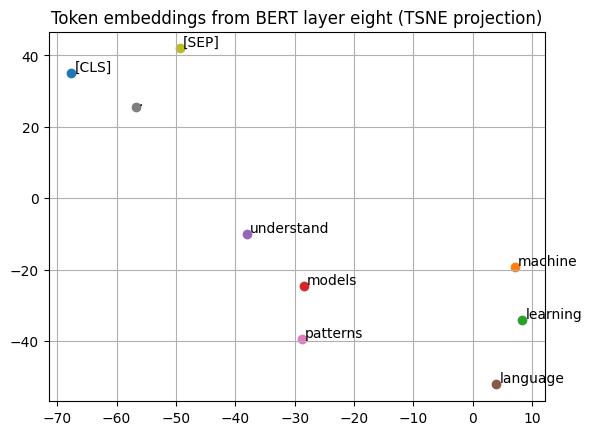

In [7]:
# detach的实用场景
import torch 
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# 加载预训练的BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # tokenizer是用来将字符串转化为token ids的，tokenizer中自带一个token id字典，对应单词
# 下面示例打印转化的token ids
print(tokenizer('I love AI.'))

# 加载BERT模型
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# output_hidden_states的作用是让模型在每次前向传播(forward)的时候，返还每一层的隐藏层(hidden_states)，而不是只返回最后一层的结果
# 如果最后我们outputs = model(**inputs)，同时设置了output_hidden_states = True，那么最后返回的是
# last_hidden_state, pooler_output, hidden_states = outputs
model.eval() # 进入评估模式

text = 'Machine learning models understand language patterns.'
inputs = tokenizer(text, return_tensors='pt') # 'pt'表示返回的tensor是pytorch tensor
with torch.no_grad():
    outputs = model(**inputs) # inputs是一个字典，'**'是用来将字典拆分成多个parameters用来作为模型的输入
    hidden_states = outputs.hidden_states

layer_eight_output = hidden_states[8][0].detach() # 意思是取模型第八层第一个batch的输出，输出shape为[seq_length, hidden_size]

# 用TSNE做将为操作
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
reduced = tsne.fit_transform(layer_eight_output) # 接受一个(n_samples, n_features)的矩阵，返回一个(n_samples, 2)的矩阵
# reduced_shape = (seq_length, 2)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]) # 取[0]去掉batch维度
for index, token in enumerate(tokens):
    x, y = reduced[index]
    plt.scatter(x, y)
    plt.text(x+0.5, y+0.5, token, fontsize = 10)
plt.title('Token embeddings from BERT layer eight (TSNE projection)')
plt.grid(True)
plt.show()


### 对上方TSNE可视化的解读
- 我们可视化的句子是：
    - 句子："Machine learning models understand language patterns."
    - 使用的是：BERT 的第8层隐藏向量
    - 降维后：每个 token 映射到 2D 平面中的一个点
- 解读：
    - 'machine', 'learning', 'language' 较靠近：表示它们的语义在第8层已被认为相似（都和“技术/AI”领域相关）
    - 'models', 'patterns', 'understand' 也聚在一起：这组更偏“行为、能力”，也是合理的子语义组
    - [CLS] 和 [SEP] 远离其他，非常合理！这两个是 特殊标记符，不具备普通词语语义，是用于句子级任务的 embedding（如分类）
    - 整体分布有方向感、不是随机噪声，说明模型中层确实在编码 token 的结构与语义关系了
    - .detach() 的价值在这里体现：并不打算训练，只是想看模型内部“怎么理解语言”，所以：
        - 避免了显存和计算图累积
        - 取出了语义向量做分析
